In [1]:
import mlrun
from mlrun.serving.remote import RemoteStep

In [2]:
project = mlrun.get_or_create_project("test-remote-step-headers")

> 2025-01-21 16:39:22,341 [info] Project loaded successfully: {"project_name":"test-remote-step-headers"}


In [3]:
%%writefile remotestep.py


def handler(context,event):
    context.logger.info(event.headers)
    return event.headers

Overwriting remotestep.py


In [4]:
func = project.set_function('remotestep.py',image='mlrun/mlrun',kind='nuclio',name='remotestep')

In [5]:
function = project.deploy_function(func.metadata.name)

> 2025-01-21 16:39:22,466 [info] Starting remote function deploy
2025-01-21 16:39:22  (info) Deploying function
2025-01-21 16:39:22  (info) Building
2025-01-21 16:39:23  (info) Staging files and preparing base images
2025-01-21 16:39:23  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-01-21 16:39:23  (info) Building processor image
2025-01-21 16:40:28  (info) Build complete
2025-01-21 16:40:36  (info) Function deploy complete
> 2025-01-21 16:40:44,105 [info] Successfully deployed function: {"external_invocation_urls":["test-remote-step-headers-remotestep.default-tenant.app.cust-cs-illl--3-6-0.iguazio-cd2.com/"],"internal_invocation_urls":["nuclio-test-remote-step-headers-remotestep.default-tenant.svc.cluster.local:8080"]}


In [6]:
function.function.invoke("/",{})

> 2025-01-21 16:40:44,166 [info] Invoking function: {"method":"GET","path":"http://nuclio-test-remote-step-headers-remotestep.default-tenant.svc.cluster.local:8080/"}


{'Connection': 'keep-alive',
 'X-Nuclio-Target': 'test-remote-step-headers-remotestep',
 'Host': 'nuclio-test-remote-step-headers-remotestep.default-tenant.svc.cluster.local:8080',
 'User-Agent': 'python-requests/2.32.3',
 'Accept-Encoding': 'gzip, deflate',
 'Accept': '*/*'}

In [7]:
%%writefile serving-func.py


def echo(event):
    event["new"] = "event"
    return event

Overwriting serving-func.py


In [8]:
serving_func = project.set_function(func="serving-func.py",image="mlrun/mlrun",kind="serving",name="serving-func")

In [9]:
graph = serving_func.set_topology("flow")

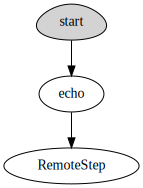

In [10]:
graph.to(name="echo",handler="echo").to(RemoteStep(url="http://"+function.function.status.internal_invocation_urls[0],headers_expression="event['custom_headers']",result_path="result")).respond()
serving_func.plot()

In [11]:
serving_func = project.deploy_function(serving_func.metadata.name)

> 2025-01-21 16:40:44,423 [info] Starting remote function deploy
2025-01-21 16:40:44  (info) Deploying function
2025-01-21 16:40:44  (info) Building
2025-01-21 16:40:45  (info) Staging files and preparing base images
2025-01-21 16:40:45  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-01-21 16:40:45  (info) Building processor image
2025-01-21 16:41:50  (info) Build complete
2025-01-21 16:42:07  (info) Function deploy complete
> 2025-01-21 16:42:17,597 [info] Successfully deployed function: {"external_invocation_urls":["test-remote-step-headers-serving-func.default-tenant.app.cust-cs-illl--3-6-0.iguazio-cd2.com/"],"internal_invocation_urls":["nuclio-test-remote-step-headers-serving-func.default-tenant.svc.cluster.local:8080"]}


In [12]:
custom_header = {"Test":"test"} 

In [13]:
res = serving_func.function.invoke("/",{"custom_headers":custom_header})

> 2025-01-21 16:42:17,712 [info] Invoking function: {"method":"POST","path":"http://nuclio-test-remote-step-headers-serving-func.default-tenant.svc.cluster.local:8080/"}


In [14]:
assert res['result'].get("Test") == custom_header.get("Test")